## PREDICTIVE ANALYTIC - Proyek 1
* Nama : Febby Ariyanti Herdiana

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"febbyariyanti01","key":"9e5a11195940e22660ae4231b2006d1f"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

## Data Loading

In [ ]:
!kaggle datasets download -d fedesoriano/heart-failure-prediction

  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 7.00MB/s]


## Ekstrak Data

In [ ]:
local_zip = '/content/heart-failure-prediction.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Data Exploration

In [ ]:
df = pd.read_csv('/content/heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df.drop(columns=['Sex','ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope', 'Oldpeak', 'HeartDisease', 'FastingBS'], inplace=True)

In [ ]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR
count,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368
std,9.432617,18.514154,109.384145,25.460334
min,28.000000,0.000000,0.000000,60.000000
25%,47.000000,120.000000,173.250000,120.000000
50%,54.000000,130.000000,223.000000,138.000000
75%,60.000000,140.000000,267.000000,156.000000
max,77.000000,200.000000,603.000000,202.000000


### Mengecek Missing Value

In [ ]:
df.isnull().sum()

Age            0
RestingBP      0
Cholesterol    0
MaxHR          0
dtype: int64

Dari output isnull().sum() terlihat bahwa setiap fitur tidak memiliki nilai NULL maupun NAN sehingga sekarang kita bisa lanjutkan ke tahapan selanjutnya yaitu menangani outliers.

### Menangani Outliers
* Pada kasus ini kita akan mendeteksi outliers dengan teknis visualisasi data atau boxplot. Kemudian kita akan menangani outliers dengan metode IQR.

Sekaran kita akan melakukan visualisasi pada fitur numerik.

1. Fitur Age

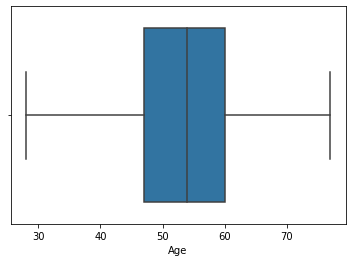

In [ ]:
sns.boxplot(x=df['Age'])

2. Fitur RestingBP

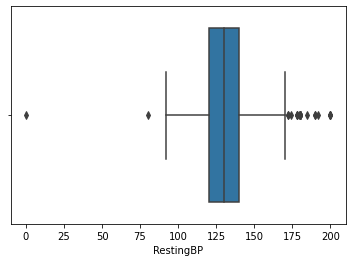

In [ ]:
sns.boxplot(x=df['RestingBP'])

3. Fitur Cholesterol

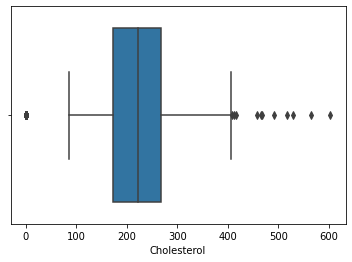

In [ ]:
sns.boxplot(x=df['Cholesterol'])

4. Fitur MaxHR

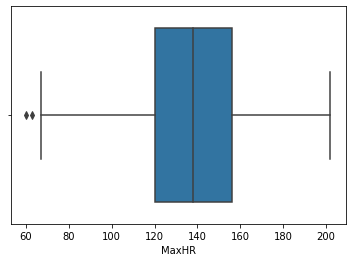

In [ ]:
sns.boxplot(x=df['MaxHR']) (Target)

pada beberapa fitur numerik di atas terdapat outliers kecuali di fitur Age. Kita akan menggunakan metode IQR untuk mengidentifikasi outlier yang berada di luar Q1 dan Q3. Nilai apa pun yang berada di luar batas ini dianggap sebagai outlier.
Menggunakan persamaan berikut:

* Batas bawah = Q1 - 1.5 * IQR
* Batas atas = Q3 + 1.5 * IQR

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

print(f"Sebelum proses menghilangkan outlier, ukuran dataset adalah {df.shape}")
# Proses menghilangkan outlier
df = df[
    ~((df < batas_bawah) | (df > batas_atas)).any(axis=1)
]

# Cek ukuran dataset setelah kita hilangkan outlier
print(f"Setelah proses menghilangkan outlier, ukuran dataset adalah {df.shape}")

Sebelum proses menghilangkan outlier, ukuran dataset adalah (918, 4)
Setelah proses menghilangkan outlier, ukuran dataset adalah (715, 4)


Banyak outlier yang dibersihkan sebanyak 918 - 715 = 203 (baris atau sampel). Kita akan cek kembali dengan boxplot setelah membersihkan outlier.

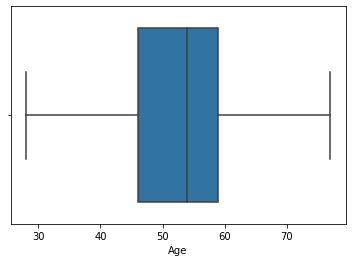

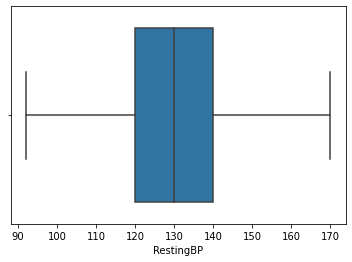

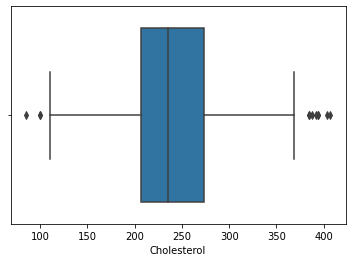

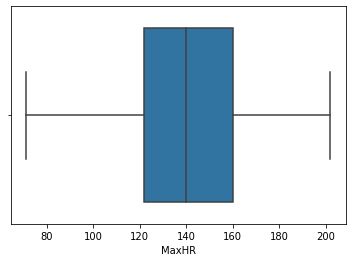

In [ ]:
for fitur in df.keys():
  sns.boxplot(x=df[fitur])
  plt.show()

Dari hasil deteksi ulang diatas dapat dilihat bahwa outlier sudah berkurang setelah proses pembersihan.

### Univariate Analysis

Analisa Fitur Numerik

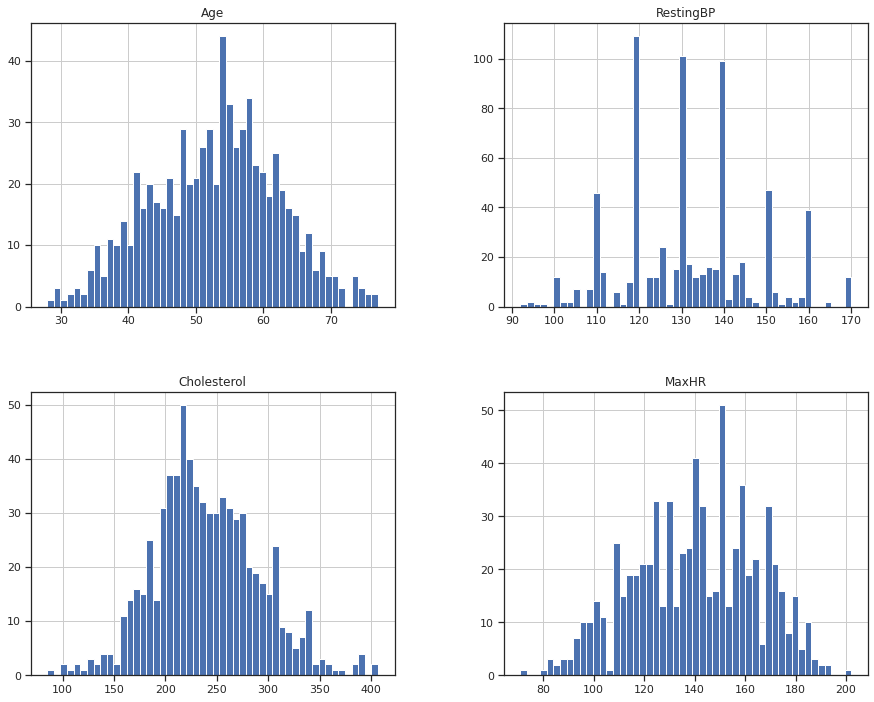

In [ ]:
sns.set(style="ticks", color_codes=True)
df.hist(bins=50, figsize=(15, 12))
plt.show()

### Multivariate Analysis

Hubungan antara Fitur Numerik
* Untuk mengamati hubungan antara fitur numerik, kita akan menggunakan fungsi pairplot().

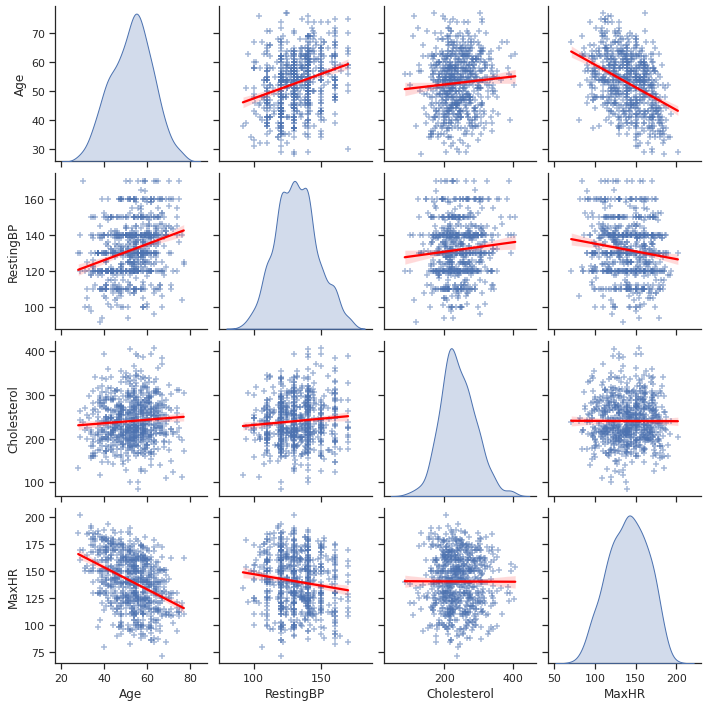

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df,
             kind="reg",
             markers="+",
             diag_kind='kde',
             plot_kws={'line_kws': {'color':'red'},
                       'scatter_kws': {'alpha': 0.5}})

Pada pola sebaran data grafik pairplot di atas, terlihat fitur Age, RestingBP dan Cholesterol memiliki korelasi kuat (negatif / berkebalikan) dengan fitur MaxHR (target). Untuk mengevaluasi skor korelasinya, kita akan gunakan fungsi corr() sebagai berikut

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

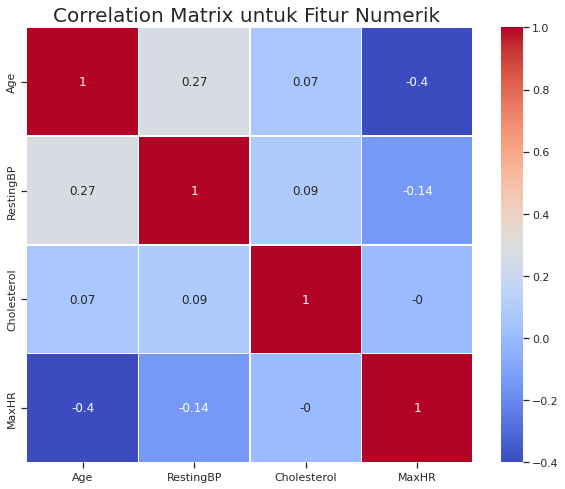

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Koefisien korelasi berkisar antara -1 dan +1. Semakin dekat nilainya ke 1 atau -1, maka korelasinya semakin kuat. Sedangkan, semakin dekat nilainya ke 0 maka korelasinya semakin lemah.

## Data Preparation

Train Test Split

Pada kasus ini kita akan menggunakan proporsi pembagian sebesar 90:10 dengan fungsi train_test_split dari sklearn.

In [ ]:
from sklearn.model_selection import train_test_split
 
X = df.drop(["MaxHR"], axis =1)
y = df["MaxHR"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)

# Cek hasil pembagian dataset
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 715
Total # of sample in train dataset: 643
Total # of sample in test dataset: 72


## Standarisasi
Proses standarisasi bertujuan untuk membuat fitur data menjadi bentuk yang lebih mudah diolah oleh algoritma. Kita akan menggunakan teknik StandarScaler dari library Scikitlearn.

StandardScaler melakukan proses standarisasi fitur dengan mengurangkan mean kemudian membaginya dengan standar deviasi untuk menggeser distribusi. StandarScaler menghasilkan distribusi deviasi sama dengan 1 dan mean sama dengan 0.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.keys())
display(X_train_scaled.describe().round(4))

,Age,RestingBP,Cholesterol
count,643.0000,643.0000,643.0000
mean,-0.0000,-0.0000,-0.0000
std,1.0008,1.0008,1.0008
min,-2.5792,-2.5511,-3.0561
25%,-0.7060,-0.7346,-0.6503
50%,0.1266,-0.0859,-0.0981
75%,0.6469,0.5629,0.6315
max,2.5201,2.5092,3.2937


### Non Linear Scaling

In [ ]:
X_train_scaled_temp = X_train_scaled.copy()
list_name_ori_fitur = X_train_scaled_temp.keys()

# Standardize=false karena sudah dilakukan standarisasi sebelumnya
yj_scaler = PowerTransformer(method='yeo-johnson', standardize=False)
yj_df = pd.DataFrame(
    yj_scaler.fit_transform(X_train_scaled_temp),
    columns=list_name_ori_fitur)

for fitur in list_name_ori_fitur:
  X_train_scaled['YJ_' + fitur] = yj_df[fitur]

Cek histogram untuk distribusi data pada setiap fitur setelah dilakukan non-linear scaling dengan metode Yeo-Johnson.

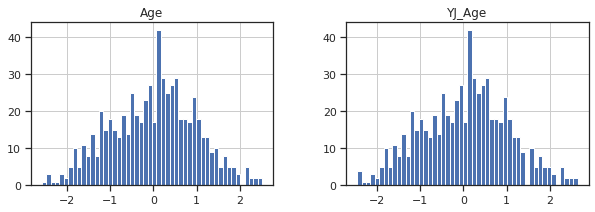

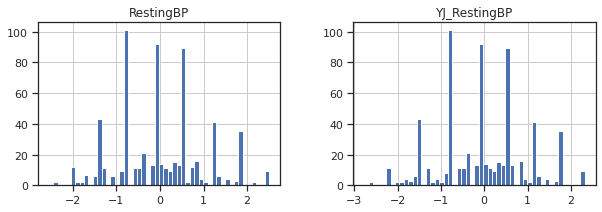

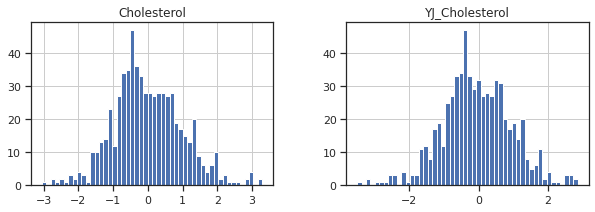

In [ ]:
sns.set(style="ticks", color_codes=True)
for fitur in list_name_ori_fitur:
  X_train_scaled[[fitur,"YJ_" + fitur]].hist(bins=50, figsize=(10, 3))
plt.show()

Selanjutnya kita drop Age, Cholesterol, RestingBP karena sudah tergantikan dengan YJ_Age, YJ_Cholesterol, YJ_RestingBP yang lebih mendekati distribusi normal

In [ ]:
X_train_scaled.drop(['Age', 'Cholesterol', 'RestingBP'], axis=1, inplace=True)
display(X_train_scaled.head())

,YJ_Age,YJ_RestingBP,YJ_Cholesterol
0,1.090936,1.155298,-0.342871
1,-0.287288,-0.086245,-0.138987
2,-0.081367,-1.317209,-0.199607
3,-0.081367,0.548715,-3.139484
4,0.127054,-0.418297,0.624043


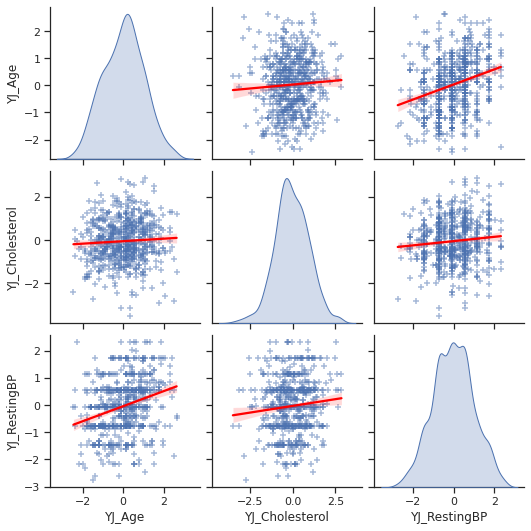

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(X_train_scaled[['YJ_Age', 'YJ_Cholesterol', 'YJ_RestingBP']],
             kind="reg",
             markers="+",
             diag_kind='kde',
             plot_kws={'line_kws': {'color':'red'},
                       'scatter_kws': {'alpha': 0.5}})

## Transformasi Data Uji
Selanjutnya kita perlu melakukan proses transformasi data terhadap data uji dengan scaler dari proses standarisasi, yj_scaler dari proses non-linear scaling (metode yeo-johnson) dan proses pca untuk digunakan pada proses evaluasi model. Biasanya proses ini dilakukan setelah proses training model, namun kita lakukan sekarang dengan tujuan supaya dapat digunakan untuk mencari nilai k optimum pada model KNN (bagian selanjutnya).

In [ ]:
# Scaling terhadap proses standarisasi pada data uji
X_test_standardize = scaler.transform(X_test)

# Scaling terhadap proses non-linear scaling (metode yeo-johnson) pada data uji
# dan menyimpan kembali dalam format DataFrame
X_test_scaled = pd.DataFrame(
    yj_scaler.transform(X_test_standardize),
    columns=["YJ_" + fitur for fitur in list_name_ori_fitur])

# Cek hasil scaling
display(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  "X does not have valid feature names, but"


,YJ_Age,YJ_RestingBP,YJ_Cholesterol
0,-1.290533,-0.086245,0.768722
1,0.022513,0.424439,-0.118889
2,1.309520,0.235717,0.271086
3,-1.191754,0.235717,-0.764601
4,0.765720,-0.086245,0.252090
...,...,...,...
67,-1.487266,0.424439,-1.380644
68,0.550908,-0.086245,0.440066
69,1.200062,-0.758673,0.117742
70,-0.287288,2.316302,-0.636302


## Model Development
Dengan menggunakan 3 algoritma untuk kasus regresi ini, dan selanjutnya mengevaluasi performa masing-masing algoritma dan menentukan mana yang dapat memberikan hasil prediksi terbaik. Tiga Algoritma tersebut yaitu :
1.  K-Nearest Neighbor ( Memiliki kelebihan yaitu mudah dipahami dan digunakan sedangkan kekurangannya kika dihadapkan pada jumlah fitur atau dimensi yang besar rawan terjadi bias)
2. Random Forest ( Kelebihannya menggunakan teknik Bagging yang berusaha melawan overfitting dengan berjalan secara paralel. Sedangkan kekurangannya ada pada kompleksitas algoritma Random Forest yang membutuhkan waktu relatif lebih lama dan daya komputasi yang lebih tinggi)
3. Boosting Algorithm ( Kelebihan algoritma Boosting adalah menggunakan teknik Boosting yang berusaha menurunkan bias dengan berjalan secara sekuensial (memperbaiki model di tiap tahapnya). Sedangkan kekurangannya hampir sama dengan algoritma Random Forest dari segi kompleksitas komputasi yang menjadikan waktu pelatihan relatif lebih lama, selain itu noisy dan outliers sangat berpengaruh dalam algoritma ini)

Untuk langkah pertama, kita akan siapkan DataFrame baru untuk menampung nilai metrik (MSE - Mean Squared Error) pada setiap model / algoritma. Hal ini berguna untuk melakukan analisa perbandingan antar model.

In [57]:
# Siapkan dataframe untuk analisis model
df_models = pd.DataFrame(index=['Train MSE', 'Test MSE'], 
                      columns=['KNN', 'RandomForest', 'Boosting'])

### Model K-Nearest Neighbor

In [58]:
list_mse = []
for k in range(1, 21):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  y_prediction = knn.predict(X_test_scaled)
  test_mse = mean_squared_error(y_test, y_prediction)
  list_mse.append(test_mse)
  print(f"Nilai MSE untuk k = {k} adalah : {test_mse}")

Nilai MSE untuk k = 1 adalah : 805.2361111111111
Nilai MSE untuk k = 2 adalah : 821.3090277777778
Nilai MSE untuk k = 3 adalah : 709.4182098765433
Nilai MSE untuk k = 4 adalah : 663.4262152777778
Nilai MSE untuk k = 5 adalah : 648.811111111111
Nilai MSE untuk k = 6 adalah : 602.4282407407406
Nilai MSE untuk k = 7 adalah : 616.7352607709751
Nilai MSE untuk k = 8 adalah : 587.9147135416666
Nilai MSE untuk k = 9 adalah : 559.3713991769548
Nilai MSE untuk k = 10 adalah : 526.7788888888889
Nilai MSE untuk k = 11 adalah : 524.0421258034894
Nilai MSE untuk k = 12 adalah : 535.6108217592592
Nilai MSE untuk k = 13 adalah : 515.7409598948061
Nilai MSE untuk k = 14 adalah : 510.66567460317464
Nilai MSE untuk k = 15 adalah : 514.2585802469135
Nilai MSE untuk k = 16 adalah : 508.27577039930554
Nilai MSE untuk k = 17 adalah : 501.6978085351788
Nilai MSE untuk k = 18 adalah : 499.8245027434841
Nilai MSE untuk k = 19 adalah : 494.0378962757771
Nilai MSE untuk k = 20 adalah : 490.9088888888889


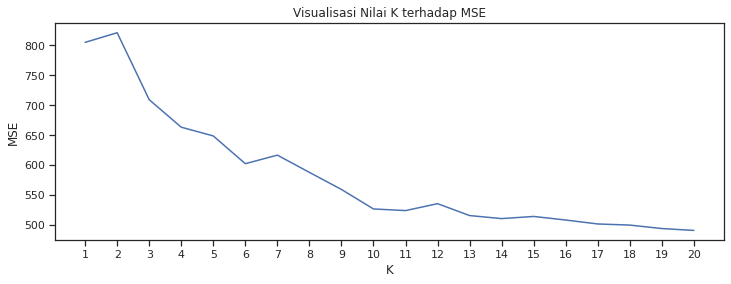

In [59]:
pd.DataFrame(list_mse, index=range(1, 21)).plot(
    xlabel="K",
    ylabel="MSE",
    legend=False,
    xticks=range(1,21), 
    figsize=(12,4),
    title='Visualisasi Nilai K terhadap MSE')

In [60]:
KNN = KNeighborsRegressor(n_neighbors=7)
KNN.fit(X_train_scaled, y_train)
df_models.loc['Train MSE', 'KNN'] = mean_squared_error(
    y_pred=KNN.predict(X_train_scaled),
    y_true=y_train)

### Random Forest

Kita akan *menggunakan* RandomForestRegressor dari library scikit-learn dengan base_estimator defaultnya yaitu DecisionTreeRegressor dan parameter-parameter (hyperparameter) yang digunakan antara lain:

* n_estimator: jumlah trees (pohon) di forest.
* max_depth: kedalaman atau panjang pohon. Ia merupakan ukuran seberapa banyak pohon dapat membelah (splitting) untuk membagi setiap node ke dalam jumlah pengamatan yang diinginkan.
random_state: digunakan untuk mengontrol random number generator yang digunakan.
* n_jobs: jumlah job (pekerjaan) yang digunakan secara paralel. Ia merupakan komponen untuk mengontrol thread atau proses yang berjalan secara paralel.n_jobs=-1 artinya semua proses berjalan secara paralel.


Untuk menentukan nilai hyperparameter (n_estimator & max_depth) di atas, kita akan melakukan tuning dengan RandomizedSearchCV.

In [61]:
params_rf = {
    "n_estimators": np.arange(10, 100, 10), # kelipatan 10 mulai dari 10 sampai 90
    "max_depth": [4, 8, 16, 32]
}

# Randomized search model
rs_model = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=123),
    param_distributions=params_rf,
    # Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring='neg_mean_squared_error', # Negatif dari nilai MSE
    verbose=3
)

rs_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..max_depth=32, n_estimators=10;, score=-573.617 total time=   1.0s
[CV 2/5] END ..max_depth=32, n_estimators=10;, score=-658.495 total time=   0.1s
[CV 3/5] END ..max_depth=32, n_estimators=10;, score=-636.415 total time=   0.1s
[CV 4/5] END ..max_depth=32, n_estimators=10;, score=-563.092 total time=   0.1s
[CV 5/5] END ..max_depth=32, n_estimators=10;, score=-623.641 total time=   0.1s
[CV 1/5] END ...max_depth=8, n_estimators=10;, score=-520.915 total time=   0.1s
[CV 2/5] END ...max_depth=8, n_estimators=10;, score=-664.891 total time=   0.1s
[CV 3/5] END ...max_depth=8, n_estimators=10;, score=-584.079 total time=   0.1s
[CV 4/5] END ...max_depth=8, n_estimators=10;, score=-555.259 total time=   0.1s
[CV 5/5] END ...max_depth=8, n_estimators=10;, score=-567.891 total time=   0.1s
[CV 1/5] END ..max_depth=16, n_estimators=80;, score=-522.496 total time=   0.3s
[CV 2/5] END ..max_depth=16, n_estimators=80;, s

RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=123),
                   param_distributions={'max_depth': [4, 8, 16, 32],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='neg_mean_squared_error', verbose=3)

Mengecek hasil tuning hyperparameter dan nilai metrik MSE.

In [62]:
print("Hasil tuning hyperparameter", rs_model.best_params_)

print("Nilai MSE model RandomSearchCV_RF dengan data latih", mean_squared_error(
    y_pred=rs_model.predict(X_train_scaled),
    y_true=y_train))
print("Nilai MSE model RandomSearchCV_RF dengan data uji", mean_squared_error(
    y_pred=rs_model.predict(X_test_scaled),
    y_true=y_test))

Hasil tuning hyperparameter {'n_estimators': 60, 'max_depth': 4}
Nilai MSE model RandomSearchCV_RF dengan data latih 427.89056952517086
Nilai MSE model RandomSearchCV_RF dengan data uji 466.24917876999564


Dari hasil output di atas diperoleh nilai MSE terbaik dalam jangkauan parameter params_rf yaitu 427.8 (dengan data train) dan 466.2 (dengan data test) dengan n_estimators: 60 dan max_depth: 4. Selanjutnya kita akan menggunakan pengaturan parameter tersebut dan menyimpan nilai MSE nya kedalam df_models yang telah kita siapkan sebelumnya.

In [63]:
RF = RandomForestRegressor(n_estimators=60, max_depth=4)
RF.fit(X_train_scaled, y_train)

df_models.loc['Train MSE', 'RandomForest'] = mean_squared_error(
    y_pred=RF.predict(X_train_scaled),
    y_true=y_train)

### Boosting Algorithm

Pada kasus ini kita akan menggunakan metode Adaptive Boosting. Untuk implementasinya kita menggunakan AdaBoostRegressor dari library sklearn dengan base_estimator defaultnya yaitu DecisionTreeRegressor hampir sama dengan RandomForestRegressor bedanya menggunakan metode teknik Boosting.

Parameter-parameter (hyperparameter) yang digunakan pada algoritma ini antara lain:

* n_estimator: jumlah estimator dan ketika mencapai nilai jumlah tersebut algoritma Boosting akan dihentikan.
* learning_rate: bobot yang diterapkan pada setiap regressor di masing-masing iterasi Boosting.
* random_state: digunakan untuk mengontrol random number generator yang digunakan.

Untuk menentukan nilai hyperparameter (n_estimator & learning_rate) di atas, kita akan melakukan tuning dengan RandomizedSearchCV.

In [64]:
params_ab = {
    "n_estimators": np.arange(10, 100, 10), # kelipatan 10 mulai dari 10 sampai 90
    "learning_rate": [0.001, 0.01, 0.1, 0.2]
}

# Randomized search model
rs_model_ab = RandomizedSearchCV(
    AdaBoostRegressor(random_state=123),
    param_distributions=params_ab,
    # Ref: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scoring='neg_mean_squared_error', # Negatif dari nilai MSE
    verbose=3
)

rs_model_ab.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.001, n_estimators=10;, score=-470.625 total time=   0.0s
[CV 2/5] END learning_rate=0.001, n_estimators=10;, score=-598.133 total time=   0.1s
[CV 3/5] END learning_rate=0.001, n_estimators=10;, score=-515.807 total time=   0.0s
[CV 4/5] END learning_rate=0.001, n_estimators=10;, score=-564.014 total time=   0.0s
[CV 5/5] END learning_rate=0.001, n_estimators=10;, score=-469.572 total time=   0.0s
[CV 1/5] END learning_rate=0.001, n_estimators=80;, score=-474.150 total time=   0.3s
[CV 2/5] END learning_rate=0.001, n_estimators=80;, score=-578.070 total time=   0.3s
[CV 3/5] END learning_rate=0.001, n_estimators=80;, score=-525.666 total time=   0.3s
[CV 4/5] END learning_rate=0.001, n_estimators=80;, score=-549.412 total time=   0.3s
[CV 5/5] END learning_rate=0.001, n_estimators=80;, score=-480.195 total time=   0.3s
[CV 1/5] END learning_rate=0.001, n_estimators=40;, score=-472.299 total time= 

RandomizedSearchCV(estimator=AdaBoostRegressor(random_state=123),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   scoring='neg_mean_squared_error', verbose=3)

Mengecek hasil tuning hyperparameter dan nilai metrik MSE

In [65]:
print("Hasil tuning hyperparameter", rs_model_ab.best_params_)

# AB = AdaBoosting
print("Nilai MSE model RandomSearchCV_AB dengan data latih", mean_squared_error(
    y_pred=rs_model_ab.predict(X_train_scaled),
    y_true=y_train))
print("Nilai MSE model RandomSearchCV_AB dengan data uji", mean_squared_error(
    y_pred=rs_model_ab.predict(X_test_scaled),
    y_true=y_test))

Hasil tuning hyperparameter {'n_estimators': 20, 'learning_rate': 0.1}
Nilai MSE model RandomSearchCV_AB dengan data latih 468.4522180017724
Nilai MSE model RandomSearchCV_AB dengan data uji 485.6626808695716


Dari hasil output di atas diperoleh nilai MSE terbaik dalam jangkauan parameter params_ab yaitu 468.4 (dengan data train) dan 485.6 (dengan data test) dengan n_estimators: 20 dan learning_rate: 0.1. Selanjutnya kita akan menggunakan pengaturan parameter tersebut dan menyimpan nilai MSE nya kedalam df_models yang telah kita siapkan sebelumnya.

In [66]:
boosting = AdaBoostRegressor(n_estimators=20, learning_rate=0.1)
boosting.fit(X_train_scaled, y_train)

df_models.loc['Train MSE', 'Boosting'] = mean_squared_error(
    y_pred=boosting.predict(X_train_scaled),
    y_true=y_train)

### Evaluasi Model

Dari proses sebelumnya, kita telah membuat tiga model yang berbeda dan juga telah melatihnya. Selanjutnya kita perlu mengevaluasi model-model tersebut menggunakan data uji dan metrik yang digunakan dalam kasus ini yaitu mean_squared_error. Hasil evaluasi kemudian kita simpan ke dalam df_models.

In [67]:
for name, model in {'KNN': KNN, 'RandomForest': RF, 'Boosting': boosting}.items():
  df_models.loc['Test MSE', name] = mean_squared_error(
      y_pred=model.predict(X_test_scaled),
      y_true=y_test)
  
# Mengecek evaluasi model
display(df_models)

,KNN,RandomForest,Boosting
Train MSE,406.660932,429.85124,466.677767
Test MSE,616.735261,465.18759,472.990753


Plot hasil evaluasi model dengan bar chart.

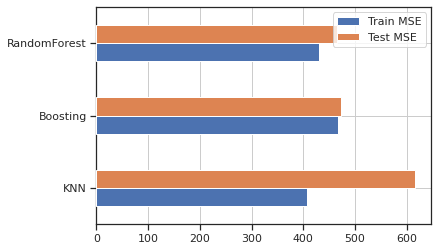

In [68]:
fig, ax = plt.subplots()
df_models.T.sort_values(by='Test MSE', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

Dari gambar di atas, terlihat bahwa, model RandomForest memberikan nilai eror (MSE) yang paling kecil. Sebelum memutuskan model terbaik untuk melakukan prediksi. Mari kita coba uji prediksi menggunakan beberapa sampel acak (5) pada data uji.

In [69]:
dict_result = {
    'index_sample': [],
    'y_true': [],
    'prediksi_KNN': [],
    'prediksi_RF': [],
    'prediksi_Boosting': []
}

X_sample = X_test_scaled.sample(5)
dict_result['index_sample'] = X_sample.index.values
dict_result['y_true'] = [y_test.iloc[idx] for idx in dict_result['index_sample']]

for name, model in {'KNN': KNN, 'RF': RF, 'Boosting': boosting}.items():
  dict_result['prediksi_' + name] = model.predict(X_sample)

display(pd.DataFrame(dict_result).set_index('index_sample'))

,y_true,prediksi_KNN,prediksi_RF,prediksi_Boosting
index_sample,,,,
38,169,138.000000,133.076362,131.962963
51,120,150.428571,153.336714,154.040000
0,167,133.142857,148.861396,150.538462
10,129,96.571429,121.724390,126.375000
22,115,117.142857,130.825632,131.711111


Terlihat bahwa prediksi dengan Random Forest (RF) memberikan hasil yang paling mendekati.

### Kesimpulan

Berdasarkan hasil evaluasi model di atas, dapat disimpulkan bahwa model terbaik untuk melakukan prediksi adalah model 
Random Forest. Dengan parameter 'n_estimators':60, 'maxdepth:'4 diperoleh nilai metrik MSE sebesar 427.8 (pada data latih) dan 466.2 (pada data uji). 

### Daftar Referensi

* [1] Rhys, Hefin. "Machine Learning with R, the Tidyverse, and MLR". Manning Publications. 2020. Tersedia: O'Reilly Media.
* [2] Fuentes, Alvaro. "Hands-on Predictive Analytics with Python". Packt Publishing. 2018. Tersedia: O'Reilly Media.
* [3] Seltman, Howard J. “Experimental Design and Analysis”.